# Predicting Star Ratings on Yelp

For this project, I used the [Yelp Open Dataset](https://www.yelp.com/dataset), which contains businesses, reviews, and user data about businesses on Yelp. I focused specifically on "business attributes," like whether a business has bike parking or free WiFi, and how those attributes correlate with a business' star rating on the site.

To make the data fit on GitHub, I wrote a [Python script](https://github.com/ahegel/yelp-dataset/blob/master/create_sample_data.py) to filter it and make sample files that include only businesses in Cleveland, Ohio. Those files are in the [data directory of this repo](https://github.com/ahegel/yelp-dataset/tree/master/data).

## Data cleaning
### Cleaning business data

In [2]:
import json
import numpy as np
import pandas as pd

In [3]:
# load and preview the data
business_data = []
with open('data/business_sample_cleveland.json') as f:
    for line in f:
        business_data.append(json.loads(line))
business_df = pd.DataFrame.from_dict(business_data)
business_df.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,2128 Warrensville Ctr Rd,{u'BusinessAcceptsCreditCards': True},jqp5TibmgJZVFKHTp3XfqQ,"[Car Wash, Automotive, Auto Detailing]",Cleveland,"{u'Monday': u'8:30-18:00', u'Tuesday': u'8:30-...",1,41.501820,-81.536776,Alpaul Automobile Wash,,44121,25,3.0,OH
1,3710 Payne Ave,"{u'BusinessParking': {u'garage': False, u'stre...",1cLXGXThDYZ5WK_KpBLtkw,"[Food, Bakeries, Coffee & Tea]",Cleveland,"{u'Monday': u'9:00-20:00', u'Friday': u'9:00-2...",1,41.509408,-81.662162,Koko Bakery,Goodrich Kirtland,44114,162,4.0,OH
2,13181 Cedar Rd,"{u'BusinessParking': {u'garage': False, u'stre...",Pawavw9U8rjxWVPU-RB7LA,"[Chinese, Restaurants]",Cleveland,"{u'Monday': u'11:30-21:30', u'Tuesday': u'11:3...",1,41.501413,-81.565982,Richie Chan's Chinese Restaurant,,44118,22,3.5,OH
3,,{},2bGCupC5mfHmEaor4pZaqg,"[Home Services, Home Cleaning, Local Services,...",Cleveland,"{u'Monday': u'0:00-0:00', u'Tuesday': u'0:00-0...",1,41.376464,-81.767764,Clean Machine,,44130,3,4.5,OH
4,1 American Rd,"{u'BusinessAcceptsCreditCards': True, u'Restau...",Q7Xw5YbS4wN7sdqZRsq4vQ,"[Event Planning & Services, Cards & Stationery...",Cleveland,{},1,41.437500,-81.763626,Cardstore,Brooklyn,44144,8,2.5,OH


In [4]:
# "name" column name is ambiguous with df.name - change it
business_df = business_df.rename(columns = {'name': 'BusinessName'})

The business categories (e.g. Restaurant, Home Cleaning) are in a list in the 'categories' column, which isn't easy to parse. By one-hot encoding them, we can more easily filter the dataset by category and use the categories as features in a model.

In [5]:
business_df['categories_clean'] = map(lambda x: '|'.join(x), business_df['categories'])
categories_df = business_df.categories_clean.str.get_dummies(sep='|')
# merge
business_df = business_df.merge(categories_df, left_index=True, right_index=True)
# remove intermediate columns (no longer needed)
business_df.drop(['categories', 'categories_clean'], axis=1, inplace=True)
business_df.head()

,address,attributes,business_id,city,hours,is_open,latitude,longitude,BusinessName,neighborhood,...,Wine & Spirits,Wine Bars,Wine Tasting Room,Wine Tours,Wineries,Women's Clothing,Wraps,Yelp Events,Yoga,Zoos
0,2128 Warrensville Ctr Rd,{u'BusinessAcceptsCreditCards': True},jqp5TibmgJZVFKHTp3XfqQ,Cleveland,"{u'Monday': u'8:30-18:00', u'Tuesday': u'8:30-...",1,41.501820,-81.536776,Alpaul Automobile Wash,,...,0,0,0,0,0,0,0,0,0,0
1,3710 Payne Ave,"{u'BusinessParking': {u'garage': False, u'stre...",1cLXGXThDYZ5WK_KpBLtkw,Cleveland,"{u'Monday': u'9:00-20:00', u'Friday': u'9:00-2...",1,41.509408,-81.662162,Koko Bakery,Goodrich Kirtland,...,0,0,0,0,0,0,0,0,0,0
2,13181 Cedar Rd,"{u'BusinessParking': {u'garage': False, u'stre...",Pawavw9U8rjxWVPU-RB7LA,Cleveland,"{u'Monday': u'11:30-21:30', u'Tuesday': u'11:3...",1,41.501413,-81.565982,Richie Chan's Chinese Restaurant,,...,0,0,0,0,0,0,0,0,0,0
3,,{},2bGCupC5mfHmEaor4pZaqg,Cleveland,"{u'Monday': u'0:00-0:00', u'Tuesday': u'0:00-0...",1,41.376464,-81.767764,Clean Machine,,...,0,0,0,0,0,0,0,0,0,0
4,1 American Rd,"{u'BusinessAcceptsCreditCards': True, u'Restau...",Q7Xw5YbS4wN7sdqZRsq4vQ,Cleveland,{},1,41.437500,-81.763626,Cardstore,Brooklyn,...,0,0,0,0,0,0,0,0,0,0


We also need to one-hot encode the business attributes and their sub-attributes, which are currently in dictionaries in the 'attributes' column.

In [6]:
business_df['attributes'].head()

0                {u'BusinessAcceptsCreditCards': True}
1    {u'BusinessParking': {u'garage': False, u'stre...
2    {u'BusinessParking': {u'garage': False, u'stre...
3                                                   {}
4    {u'BusinessAcceptsCreditCards': True, u'Restau...
Name: attributes, dtype: object

In [7]:
business_df = business_df.join(pd.DataFrame(business_df['attributes'].to_dict()).T)
# further split sub-attributes into their own columns
cols_to_split = ['BusinessParking', 'Ambience', 'BestNights', 'GoodForMeal', 'HairSpecializesIn', 'Music']
for col_to_split in cols_to_split:
    new_df = pd.DataFrame(business_df[col_to_split].to_dict()).T
    new_df.columns = [col_to_split + '_' + str(col) for col in new_df.columns]
    business_df = business_df.join(new_df)

business_df.drop(['attributes'] + cols_to_split, axis=1, inplace=True)
business_df.head()

,address,business_id,city,hours,is_open,latitude,longitude,BusinessName,neighborhood,postal_code,...,HairSpecializesIn_kids,HairSpecializesIn_perms,HairSpecializesIn_straightperms,Music_background_music,Music_dj,Music_jukebox,Music_karaoke,Music_live,Music_no_music,Music_video
0,2128 Warrensville Ctr Rd,jqp5TibmgJZVFKHTp3XfqQ,Cleveland,"{u'Monday': u'8:30-18:00', u'Tuesday': u'8:30-...",1,41.501820,-81.536776,Alpaul Automobile Wash,,44121,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3710 Payne Ave,1cLXGXThDYZ5WK_KpBLtkw,Cleveland,"{u'Monday': u'9:00-20:00', u'Friday': u'9:00-2...",1,41.509408,-81.662162,Koko Bakery,Goodrich Kirtland,44114,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,13181 Cedar Rd,Pawavw9U8rjxWVPU-RB7LA,Cleveland,"{u'Monday': u'11:30-21:30', u'Tuesday': u'11:3...",1,41.501413,-81.565982,Richie Chan's Chinese Restaurant,,44118,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,,2bGCupC5mfHmEaor4pZaqg,Cleveland,"{u'Monday': u'0:00-0:00', u'Tuesday': u'0:00-0...",1,41.376464,-81.767764,Clean Machine,,44130,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1 American Rd,Q7Xw5YbS4wN7sdqZRsq4vQ,Cleveland,{},1,41.437500,-81.763626,Cardstore,Brooklyn,44144,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


While most of these new columns we just made are boolean attributes, a number of them are categorical, which need some special handling. We need to encode them so models can use them as features.

In [8]:
# columns with non-boolean categorical values:
cols_to_split = ['AgesAllowed', 'Alcohol', 'BYOBCorkage', 'NoiseLevel', 'RestaurantsAttire', 'Smoking', 'WiFi']
new_cat = pd.concat([pd.get_dummies(business_df[col], prefix=col, prefix_sep='_') for col in cols_to_split], axis=1)
# keep all columns (not n-1) because 0's for all of them indicates that the data was missing (useful info)
business_df = pd.concat([business_df, new_cat], axis=1)
business_df.drop(cols_to_split, inplace=True, axis=1)
business_df.head()

,address,business_id,city,hours,is_open,latitude,longitude,BusinessName,neighborhood,postal_code,...,NoiseLevel_very_loud,RestaurantsAttire_casual,RestaurantsAttire_dressy,RestaurantsAttire_formal,Smoking_no,Smoking_outdoor,Smoking_yes,WiFi_free,WiFi_no,WiFi_paid
0,2128 Warrensville Ctr Rd,jqp5TibmgJZVFKHTp3XfqQ,Cleveland,"{u'Monday': u'8:30-18:00', u'Tuesday': u'8:30-...",1,41.501820,-81.536776,Alpaul Automobile Wash,,44121,...,0,0,0,0,0,0,0,0,0,0
1,3710 Payne Ave,1cLXGXThDYZ5WK_KpBLtkw,Cleveland,"{u'Monday': u'9:00-20:00', u'Friday': u'9:00-2...",1,41.509408,-81.662162,Koko Bakery,Goodrich Kirtland,44114,...,0,0,0,0,0,0,0,1,0,0
2,13181 Cedar Rd,Pawavw9U8rjxWVPU-RB7LA,Cleveland,"{u'Monday': u'11:30-21:30', u'Tuesday': u'11:3...",1,41.501413,-81.565982,Richie Chan's Chinese Restaurant,,44118,...,0,1,0,0,0,0,0,0,1,0
3,,2bGCupC5mfHmEaor4pZaqg,Cleveland,"{u'Monday': u'0:00-0:00', u'Tuesday': u'0:00-0...",1,41.376464,-81.767764,Clean Machine,,44130,...,0,0,0,0,0,0,0,0,0,0
4,1 American Rd,Q7Xw5YbS4wN7sdqZRsq4vQ,Cleveland,{},1,41.437500,-81.763626,Cardstore,Brooklyn,44144,...,0,0,0,0,0,0,0,0,0,0


There are a lot of missing values. We can clean the missing values by giving them a value that's not True or False, but right in the middle: 0.5.

In [9]:
# convert true/false columns to 0/.5/1 for false/missing/true
print business_df['BusinessAcceptsCreditCards'].head(10)
business_df = business_df.fillna(0.5).apply(pd.to_numeric, errors='ignore')  # can narrow with .iloc[:,648:722] if necessary
business_df['BusinessAcceptsCreditCards'].head(10)

0     True
1     True
2    False
3      NaN
4     True
5     True
6     True
7      NaN
8     True
9     True
Name: BusinessAcceptsCreditCards, dtype: object


0    1.0
1    1.0
2    0.0
3    0.5
4    1.0
5    1.0
6    1.0
7    0.5
8    1.0
9    1.0
Name: BusinessAcceptsCreditCards, dtype: float64

In [10]:
# deal with missing values in postal code
print business_df['postal_code'].isnull().sum()
business_df['postal_code'] = business_df['postal_code'].fillna(0)
print business_df['postal_code'].isnull().sum()

13
0


In [11]:
# check that all nulls are removed
business_df.isnull().sum().sum()

0

### Cleaning check-in data
This data shows, for each business, the number of check-ins for each hour of the day. I didn't use this data for prediction in this project, but I cleaned it to use for future projects.

In [12]:
checkin_data = []
with open('data/checkin_sample_cleveland.json') as f:
    for line in f:
        checkin_data.append(json.loads(line))
checkin_df = pd.DataFrame.from_dict(checkin_data)
checkin_df.head()

,business_id,time
0,Zn3GV2xa9a-8bHjUM-2sow,"{u'Monday': {u'1:00': 1}, u'Thursday': {u'23:0..."
1,lia867Aug7wdfpo5t86W3Q,{u'Friday': {u'0:00': 1}}
2,8U6EmwNaeTnhKbhBgIZPGQ,"{u'Monday': {u'5:00': 1, u'4:00': 3, u'1:00': ..."
3,KsYAGLP4yC7FbfixaeCHsA,"{u'Monday': {u'14:00': 4, u'22:00': 4, u'12:00..."
4,bo3z3-WUNblcRKRrWqeTAg,"{u'Monday': {u'19:00': 10, u'14:00': 3, u'17:0..."


The 'time' column is a dictionary - we need to separate the data for each hour into its own column.

In [13]:
# separate the values from the dict so they're a list of ['Day', 'time', count]
checkin_df['time_clean'] = map(lambda (x, y): map(lambda (k, v): map(lambda(i, value): [k, value, v.values()[i]], enumerate(v)), y.iteritems()), checkin_df['time'].iteritems())
# flatten the list so each day is no longer in its own list
checkin_df['time_clean'] = map(lambda l: [item for sublist in l for item in sublist], checkin_df['time_clean'])
# make it a cleaner dict where key='Day Time', value=count
checkin_df['time_clean'] = map(lambda x: {s + ' ' + t: u for (s, t, u) in x}, checkin_df['time_clean'])
# add column for each day/time with counts as values
new_checkin_df = checkin_df.join(pd.DataFrame(checkin_df["time_clean"].to_dict()).T).fillna(0)
# remove intermediate columns (no longer needed)
new_checkin_df.drop(['time', 'time_clean'], axis=1, inplace=True)
new_checkin_df.head()

,business_id,Friday 0:00,Friday 10:00,Friday 11:00,Friday 12:00,Friday 13:00,Friday 14:00,Friday 15:00,Friday 16:00,Friday 17:00,...,Wednesday 22:00,Wednesday 23:00,Wednesday 2:00,Wednesday 3:00,Wednesday 4:00,Wednesday 5:00,Wednesday 6:00,Wednesday 7:00,Wednesday 8:00,Wednesday 9:00
0,Zn3GV2xa9a-8bHjUM-2sow,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,lia867Aug7wdfpo5t86W3Q,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8U6EmwNaeTnhKbhBgIZPGQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,KsYAGLP4yC7FbfixaeCHsA,4.0,0.0,1.0,0.0,4.0,0.0,3.0,1.0,1.0,...,0.0,0.0,2.0,2.0,1.0,0.0,2.0,0.0,1.0,1.0
4,bo3z3-WUNblcRKRrWqeTAg,5.0,42.0,10.0,1.0,2.0,2.0,4.0,4.0,0.0,...,6.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0


Merge this new checkin data with business_df.

In [14]:
business_df = business_df.merge(new_checkin_df, left_on='business_id', right_on='business_id', how='left')
business_df.head()

,address,business_id,city,hours,is_open,latitude,longitude,BusinessName,neighborhood,postal_code,...,Wednesday 22:00,Wednesday 23:00,Wednesday 2:00,Wednesday 3:00,Wednesday 4:00,Wednesday 5:00,Wednesday 6:00,Wednesday 7:00,Wednesday 8:00,Wednesday 9:00
0,2128 Warrensville Ctr Rd,jqp5TibmgJZVFKHTp3XfqQ,Cleveland,"{u'Monday': u'8:30-18:00', u'Tuesday': u'8:30-...",1,41.501820,-81.536776,Alpaul Automobile Wash,,44121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3710 Payne Ave,1cLXGXThDYZ5WK_KpBLtkw,Cleveland,"{u'Monday': u'9:00-20:00', u'Friday': u'9:00-2...",1,41.509408,-81.662162,Koko Bakery,Goodrich Kirtland,44114.0,...,12.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13181 Cedar Rd,Pawavw9U8rjxWVPU-RB7LA,Cleveland,"{u'Monday': u'11:30-21:30', u'Tuesday': u'11:3...",1,41.501413,-81.565982,Richie Chan's Chinese Restaurant,,44118.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,,2bGCupC5mfHmEaor4pZaqg,Cleveland,"{u'Monday': u'0:00-0:00', u'Tuesday': u'0:00-0...",1,41.376464,-81.767764,Clean Machine,,44130.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1 American Rd,Q7Xw5YbS4wN7sdqZRsq4vQ,Cleveland,{},1,41.437500,-81.763626,Cardstore,Brooklyn,44144.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


But not all of the businesses had check-in data. I set missing values to 0 if I had no check-in data for them.

In [15]:
business_df.iloc[:, 648:] = business_df.iloc[:, 648:].fillna(0)

Our final business data looks like this:

In [16]:
basic_cols = business_df.columns[:13]
print basic_cols

category_cols = business_df.columns[13:648]
print category_cols

attribute_cols = business_df.columns[648:737]
print attribute_cols

checkin_cols = business_df.columns[737:]
print checkin_cols

attribute_checkin_cols = business_df.columns[648:]
#business_df.info(verbose=True, null_counts=True)

Index([     u'address',  u'business_id',         u'city',        u'hours',
            u'is_open',     u'latitude',    u'longitude', u'BusinessName',
       u'neighborhood',  u'postal_code', u'review_count',        u'stars',
              u'state'],
      dtype='object')
Index([u'Accessories', u'Active Life', u'Acupuncture', u'Adult',
       u'Adult Education', u'Adult Entertainment', u'African',
       u'Air Duct Cleaning', u'Airlines', u'Airport Lounges',
       ...
       u'Wine & Spirits', u'Wine Bars', u'Wine Tasting Room', u'Wine Tours',
       u'Wineries', u'Women's Clothing', u'Wraps', u'Yelp Events', u'Yoga',
       u'Zoos'],
      dtype='object', length=635)
Index([                 u'AcceptsInsurance',
                                    u'BYOB',
                             u'BikeParking',
                  u'BusinessAcceptsBitcoin',
              u'BusinessAcceptsCreditCards',
                       u'ByAppointmentOnly',
                                  u'Caters',
        

## Exploring the data

Let's start by visualizing where our businesses are, colored by neighborhood:

In [19]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline

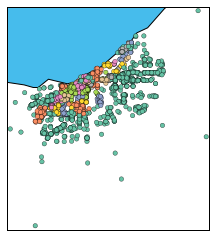

In [20]:
# decide map range based on min and max latitude/longitudes
margin = .01
lat_min = min(business_df['latitude'].values) - margin
lat_max = max(business_df['latitude'].values) + margin
lon_min = min(business_df['longitude'].values) - margin
lon_max = max(business_df['longitude'].values) + margin

# create map
m = Basemap(llcrnrlon=lon_min,
            llcrnrlat=lat_min,
            urcrnrlon=lon_max,
            urcrnrlat=lat_max,
            lat_0=(lat_max - lat_min)/2,
            lon_0=(lon_max - lon_min)/2,
            projection='merc',
            resolution='h',
            area_thresh=10000.)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='white', lake_color='#46bcec')
lons, lats = m(business_df['longitude'].values, business_df['latitude'].values)

# plot points colored by neighborhood
#col = business_df['neighborhood'].replace({u'': 'b'})
color_labels = business_df['neighborhood'].unique()
rgb_values = sns.color_palette("Set2", len(color_labels))
color_map = dict(zip(color_labels, rgb_values))
m.scatter(lons, lats, marker='o', c=business_df['neighborhood'].map(color_map), zorder=5)
plt.show()

What does the distribution of star ratings look like?

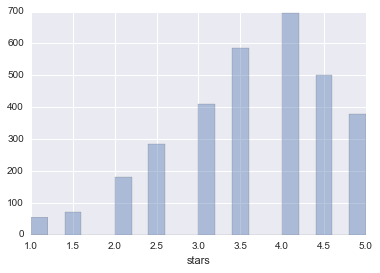

In [21]:
sns.distplot(business_df['stars'], kde=False);

Is a business' star rating affected by whether or not it has, for example, free WiFi? It doesn't seem like it:

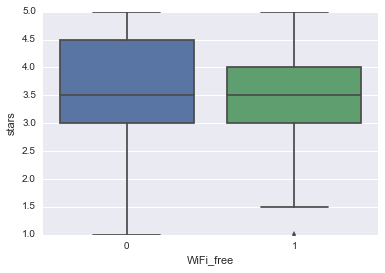

In [23]:
sns.boxplot(x='WiFi_free', y='stars', data=business_df);

Let's look at the average star ratings by category for the highest- and lowest-rated business categories (given that they have at least 5 ratings):

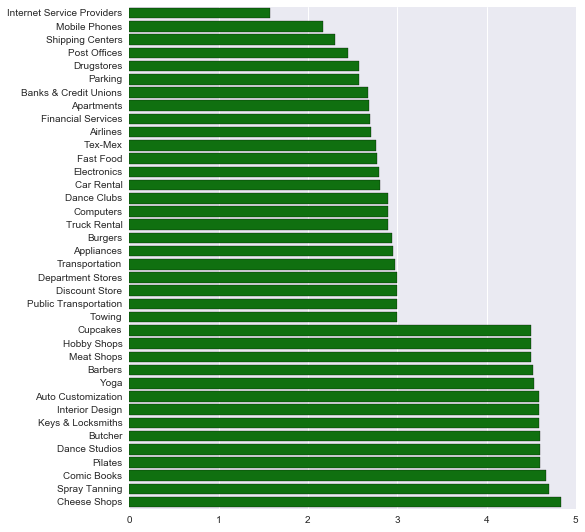

In [25]:
min_ratings = 5
cats = business_df.columns[13:648].values  # category columns
upper_perc = np.percentile(business_df['stars'], 85)
lower_perc = np.percentile(business_df['stars'], 25)
cat_names = []
cat_means = []
for cat in cats:
    if business_df[business_df[cat] == 1].stars.value_counts().sum() >= min_ratings:
        curr_mean = business_df[business_df[cat] == 1].stars.mean()
        if curr_mean >= upper_perc or curr_mean <= lower_perc:
            cat_names.append(cat)
            cat_means.append(business_df[business_df[cat] == 1].stars.mean())

# plot without sorting
#ax = sns.barplot(x=cat_means, y=cats[:how_many], color='g')

# sort by least to most stars
yx = zip(cat_means, cat_names)
yx.sort()
y_sorted, x_sorted = zip(*yx)

fig, ax = plt.subplots()
fig.set_size_inches(8, len(cat_means)/4)
ax = sns.barplot(x=y_sorted, y=x_sorted, color='g')

Let's get some idea of the distribution of ratings for each category:

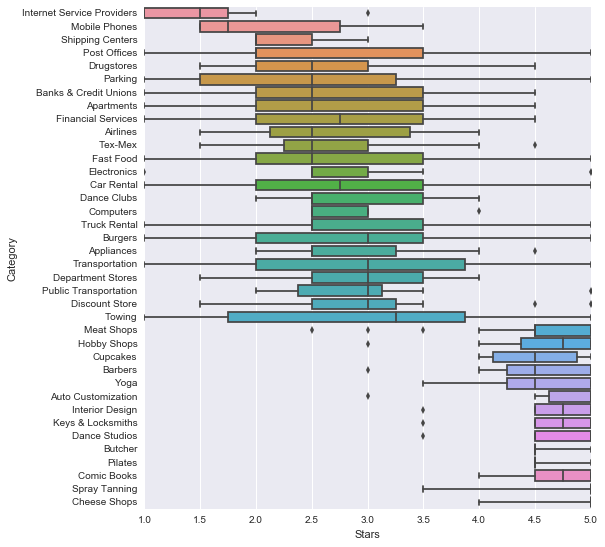

In [293]:
boxplot_df = pd.DataFrame([])
for i, cat in enumerate(cats):
    currgroup = business_df[business_df[cat] == 1]
    if currgroup.stars.value_counts().sum() >= min_ratings:
        if currgroup.stars.mean() >= upper_perc or currgroup.stars.mean() <= lower_perc:
            stars_df = pd.DataFrame([])
            stars_df['Stars'] = currgroup.stars
            stars_df['Category'] = currgroup[cat].name
            stars_df['Mean'] = currgroup.stars.mean()
            boxplot_df = pd.concat([boxplot_df, stars_df])

boxplot_df = boxplot_df.sort_values(['Mean']).reset_index(drop=True)

fig, ax = plt.subplots()
fig.set_size_inches(8, boxplot_df['Category'].nunique()/4)
ax = sns.boxplot(x='Stars', y='Category', data=boxplot_df)

Which business attributes correlate most with a business' star rating? There are too many attributes to show the matrix for all of them, but below you can see that bike parking seems to be slightly correlated with star rating.

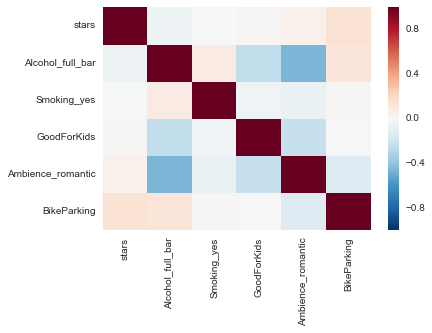

In [294]:
corr_df = business_df[['stars', 'Alcohol_full_bar', 'Smoking_yes', 'GoodForKids', 'Ambience_romantic', 'BikeParking']]
sns.heatmap(corr_df.corr());

## Predictive Modeling

What business attributes predict good ratings? It's probably a different set of attributes for each type of business, so let's choose one business category to work with for now (the one with the most data).

In [295]:
# find the most represented categories
business_df.iloc[:, 13:648].sum().sort_values(ascending=False).head(10)

Restaurants                  1361
Food                          586
Nightlife                     448
Bars                          400
Shopping                      394
American (Traditional)        226
Automotive                    193
Event Planning & Services     186
American (New)                185
Beauty & Spas                 185
dtype: int64

So we'll try to predict which attributes correlate with restaurants' star ratings. This is a regression problem. Let's start with the simplest model, linear regression.

### Linear regression

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [29]:
# just look at one business category
select_df = business_df[business_df['Restaurants'] == 1]
# just look at attribute columns
model_df = select_df[attribute_cols]  # use just attributes not basic data or check-in columns
model_df['is_open'] = business_df['is_open']  # add one basic data column; not sure why this causes error

feature_cols = model_df.columns
X = model_df
y = select_df.stars

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=1)
print X_train.shape
print X_test.shape

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
print 'Train RMSE:'
print np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))

y_pred_test = lr.predict(X_test)
print 'Test RMSE:'
print np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
print ''
print lr.intercept_
res = pd.DataFrame({'feature': feature_cols, 'coef': lr.coef_})
print res.sort_values(by=['coef'], ascending=False)

(1224, 90)
(137, 90)
Train RMSE:
0.725508876632
Test RMSE:
0.819459389018

4.74737401695
        coef                     feature
63  0.496341               Music_karaoke
8   0.470146                     Corkage
11  0.433901              GoodForDancing
34  0.349140           Ambience_intimate
6   0.310903                      Caters
15  0.291521                 Open24Hours
62  0.278597               Music_jukebox
85  0.248076                 Smoking_yes
81  0.247486    RestaurantsAttire_dressy
13  0.244259                   HappyHour
2   0.211831                 BikeParking
27  0.168123      BusinessParking_street
37  0.151417             Ambience_trendy
73  0.150386              BYOBCorkage_no
33  0.130004            Ambience_hipster
51  0.116231           GoodForMeal_lunch
35  0.112323           Ambience_romantic
60  0.107080      Music_background_music
47  0.097941          GoodForMeal_brunch
1   0.094606                        BYOB
70  0.087520       Alcohol_beer_and_wine
42  0.081

E:\Users\ahegel\Anaconda\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Now let's use cross-validation instead of train-test split for a better estimation of the RMSE:

In [30]:
from sklearn.model_selection import KFold, cross_val_score

In [300]:
# just look at one business category
select_df = business_df[business_df['Restaurants'] == 1]
# just look at attribute columns
model_df = select_df[attribute_cols]  # use just attributes not basic data or check-in columns
model_df['is_open'] = business_df['is_open']  # add one basic data column; not sure why this causes error

feature_cols = model_df.columns
X = model_df
y = select_df.stars

lr = LinearRegression()
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
cross_val_scores = cross_val_score(lr, X, y, scoring='neg_mean_squared_error', cv=kfold)
print '10-fold RMSEs:'
print [np.sqrt(-x) for x in cross_val_scores]
print 'CV RMSE:'
print np.sqrt(-np.mean(cross_val_scores))  # RMSE is the sqrt of the avg of MSEs
print 'Std of CV RMSE:'
print np.std(cross_val_scores)

E:\Users\ahegel\Anaconda\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


10-fold RMSEs:
[0.81945938901835425, 0.83511431067814323, 0.81360432578667641, 0.78351895793102355, 0.72442754333736292, 0.81922978021289738, 0.69649787974022814, 0.70799712619598021, 0.73246459667823371, 0.77991457212645876]
CV RMSE:
0.772777885893
Std of CV RMSE:
0.0750479652377


Would it improve the model to add polynomial features? NO IT'S A DISASTER

In [301]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_predict

In [302]:
pf = PolynomialFeatures(degree=2,interaction_only=True)
X_pf = pf.fit_transform(X)  # only apply to attribute columns
print X.shape
print X_pf.shape

lr2 = LinearRegression()
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
pf_cross_val_scores = cross_val_score(lr2, X_pf, y, scoring='neg_mean_squared_error', cv=kfold)

pf_cross_val_predicts = cross_val_predict(lr2, X_pf, y, cv=kfold)
print pf_cross_val_predicts[:20]

print '10-fold RMSEs:'
print [np.sqrt(-x) for x in pf_cross_val_scores]
print 'CV RMSE:'
print np.sqrt(-np.mean(pf_cross_val_scores))  # RMSE is the sqrt of the avg of MSEs
print 'Std of CV RMSE:'
print np.std(pf_cross_val_scores)

(1361, 90)
(1361L, 4096L)
[  2.68005371e+00  -5.05920410e-01   4.14555265e+10  -3.81698813e+08
   4.70880127e+00  -6.12182617e-01  -7.32581541e+09   4.09997559e+00
  -2.65247345e+00  -3.68597738e+08  -1.83296194e+09  -2.83422209e+10
   1.08027344e+01   1.14725244e+10   9.43292236e+00  -1.71454776e+09
   8.10113525e+00   2.04096222e+00   5.60839844e+00   6.71523914e+09]
10-fold RMSEs:
[4078652212.8363147, 57582884979.609673, 5292154697.2948751, 4716803429.2906542, 18619025810.044247, 7576492489.5891638, 35476945698.797134, 1104564023.8241787, 1067985650.6034213, 14220952772.842295]
CV RMSE:
22912791998.9
Std of CV RMSE:
9.99414144846e+20


Could this have happened because of overfitting? Let's see if regularization will help. We can use ridge regularization to prevent overfitting.

In [35]:
from sklearn.linear_model import RidgeCV

In [304]:
ridge = RidgeCV(store_cv_values=True)
ridge.fit(X, y)

ridge_MSEs = ridge.cv_values_
print 'Ridge CV RMSE:'
print np.sqrt(np.mean(ridge_MSEs))

# try on expanded polynomial features
ridge_pf = RidgeCV(store_cv_values=True)
ridge_pf.fit(X_pf, y)

ridge_pf_MSEs = ridge_pf.cv_values_
print 'Ridge PF CV RMSE:'
print np.sqrt(np.mean(ridge_pf_MSEs))

Ridge CV RMSE:
0.765812751554
Ridge PF CV RMSE:
1.15939788396


### Decision tree regressor

We can also see if a decision tree regressor does better at predicting restaurants' star ratings from their business attributes.

In [305]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz

RMSE:
0.81403320638



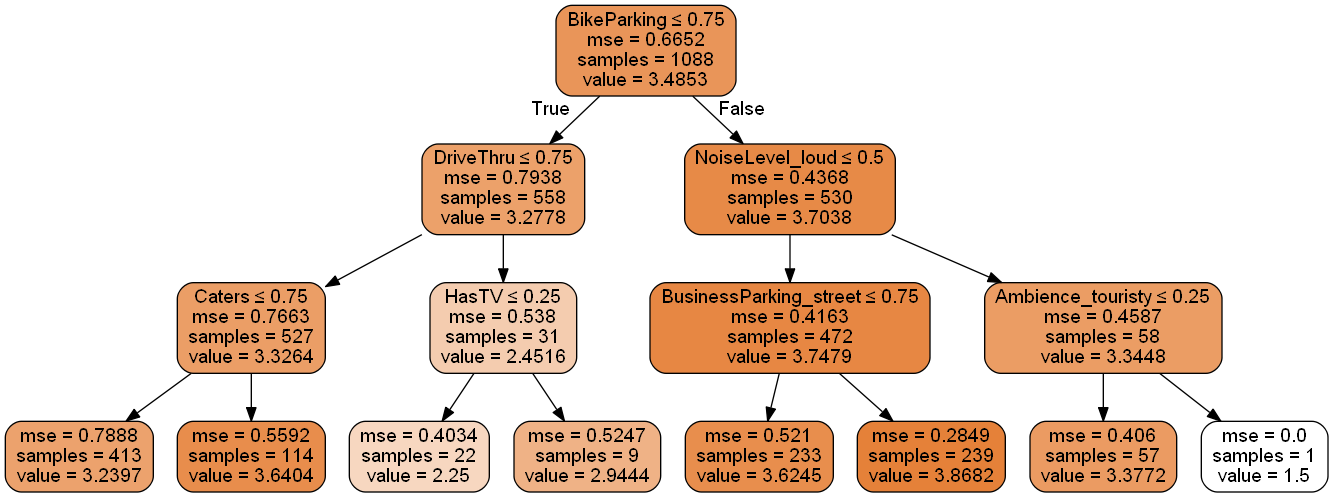

In [306]:
# use business attributes to predict star rating, same as above
rg_X_train, rg_X_test, rg_y_train, rg_y_test = train_test_split(X, y, test_size=.2, random_state=1)
features = [x.encode('utf-8') for x in model_df.columns.values]

rg = DecisionTreeRegressor(max_depth=3)
rg.fit(rg_X_train, rg_y_train)
print 'RMSE:'
print np.sqrt(metrics.mean_squared_error(rg_y_test, rg.predict(rg_X_test)))
print ''

# visualize the tree
dot_data = StringIO()  
export_graphviz(rg, out_file=dot_data,  
                    feature_names=features,  
                    filled=True, rounded=True,  
                    special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [307]:
# most important features of the decision tree regressor
pd.DataFrame({'feature': model_df.columns.values, 'importance': rg.feature_importances_}).sort_values(by='importance', ascending=False).head()

,feature,importance
2,BikeParking,0.456675
10,DriveThru,0.207412
6,Caters,0.132761
77,NoiseLevel_loud,0.077685
27,BusinessParking_street,0.064889


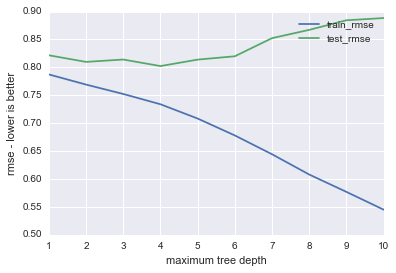

In [308]:
depths = range(1,11)
train_rmse, test_rmse = [],[]
for depth in depths:
    decision_tree = DecisionTreeRegressor(max_depth=depth, random_state=1)
    decision_tree.fit(rg_X_train, rg_y_train)
    curr_train_rmse = np.sqrt(metrics.mean_squared_error(rg_y_train, decision_tree.predict(rg_X_train)))
    curr_test_rmse = np.sqrt(metrics.mean_squared_error(rg_y_test, decision_tree.predict(rg_X_test)))
    train_rmse.append(curr_train_rmse)
    test_rmse.append(curr_test_rmse)
sns.mpl.pyplot.plot(depths,train_rmse,label='train_rmse')
sns.mpl.pyplot.plot(depths,test_rmse,label='test_rmse')
sns.mpl.pyplot.xlabel("maximum tree depth")
sns.mpl.pyplot.ylabel("rmse - lower is better")
sns.mpl.pyplot.legend();

Now let's try it with cross-validation instead of train-test split for a better estimation of the RMSE:

In [33]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz

10-fold RMSEs:
[0.78089349602728642, 0.83333076643151305, 0.91692296369391768, 0.77777318906110482, 0.71854278752901779, 0.84655332566646435, 0.75466805147091354, 0.80435600177247635, 0.76722365065777998, 0.79058793616645373]
CV RMSE:
0.800814822823
Std of CV RMSE:
0.0862806094411


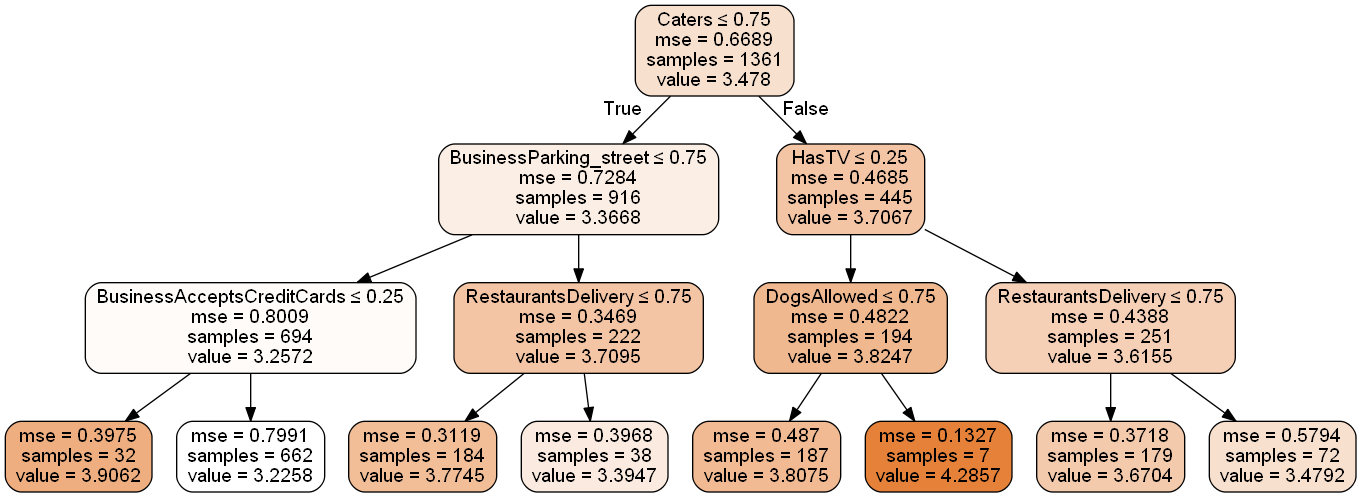

In [310]:
# use business attributes to predict star rating, same as above
feature_cols = [x.encode('utf-8') for x in model_df.columns.values]
X = model_df
y = select_df.stars

rg = DecisionTreeRegressor(max_depth=3, max_features=10)
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
cross_val_scores = cross_val_score(rg, X, y, scoring='neg_mean_squared_error', cv=kfold)
print '10-fold RMSEs:'
print [np.sqrt(-x) for x in cross_val_scores]
print 'CV RMSE:'
print np.sqrt(-np.mean(cross_val_scores))  # RMSE is the sqrt of the avg of MSEs
print 'Std of CV RMSE:'
print np.std(cross_val_scores)

# visualize the tree
rg.fit(X, y)
dot_data = StringIO()
export_graphviz(rg, out_file=dot_data,  
                    feature_names=feature_cols,  
                    filled=True, rounded=True,  
                    special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

This isn't better (lower) than our linear regression RMSE of 0.77 or the ridge RMSE of 0.76. Can we improve it by optimizing the parameters of the decision tree regressor model?

In [39]:
from sklearn.model_selection import GridSearchCV

Best RMSE and parameters:
0.77238976071 {'max_features': 0.8, 'max_depth': 5}


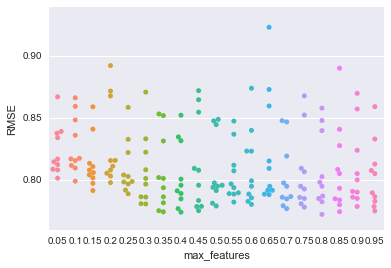

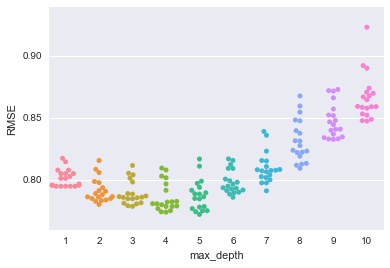

In [312]:
# grid search to find best parameters
rg_grid = DecisionTreeRegressor(random_state=1)
max_depth_range = range(1, 11)
max_features_range = [x/20.0 for x in range(1, 20)]
param_grid = dict(max_depth=max_depth_range, max_features=max_features_range)
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
grid = GridSearchCV(rg_grid, param_grid, cv=kfold, scoring='neg_mean_squared_error')
grid.fit(X, y)
#print grid.cv_results_['mean_test_score']
tree_model = grid.best_estimator_
print 'Best RMSE and parameters:'
print np.sqrt(-grid.best_score_), grid.best_params_
#for mean, param in zip(grid.cv_results_['mean_test_score'], grid.cv_results_['params']):
#    print mean, param

scores = np.sqrt([-x for x in grid.cv_results_['mean_test_score']])  # convert to RMSE
max_f = [x.values()[0] for x in grid.cv_results_['params']]
max_d = [x.values()[1] for x in grid.cv_results_['params']]

rg_grid_results = pd.DataFrame({'RMSE': scores,
                                'max_features': max_f,
                                'max_depth': max_d})

# plot the results
sns.swarmplot(x='max_features', y='RMSE', data=rg_grid_results)
plt.show()
f2 = sns.swarmplot(x='max_depth', y='RMSE', data=rg_grid_results)
plt.show()

Let's put it all together and see which models work the best at predicting star rating from business attributes.

In [37]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.svm import SVR

  models      RMSE
5    SVR  0.759434


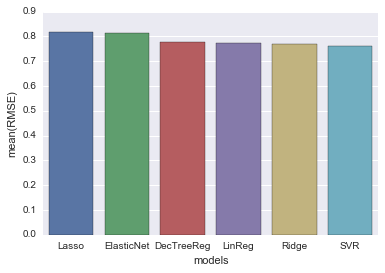

In [40]:
# GridSearch to see if optimizing the parameters will improve (lower) the RMSE
reg_models = [('LinReg', LinearRegression(), {'normalize': [True, False]}),
              ('DecTreeReg', DecisionTreeRegressor(), {'max_depth': range(2, 10, 2), 'max_features': [0.25, 0.5, 0.75, 1.0]}),
              ('Lasso', Lasso(), {'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}),
              ('Ridge', Ridge(), {'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}),
              ('ElasticNet', ElasticNet(), {'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}),
              ('SVR', SVR(), {'C': [1e0, 1e1, 1e2, 1e3], 'gamma': np.logspace(-2, 2, 5)})]

names = []
params = []
results = []
for name, model, param in reg_models:
    kfold = KFold(n_splits=10, shuffle=True, random_state=1)
    reg_grid = GridSearchCV(model, param, cv=kfold, scoring='neg_mean_squared_error')
    reg_grid.fit(X, y)
    # just keep the results using the best parameters
    best_model = reg_grid.best_estimator_
    names.append(name)
    params.append(reg_grid.best_params_)
    results.append(np.sqrt(-reg_grid.best_score_))  # convert to RMSE

result_df = pd.DataFrame({'models': names, 'results': results})
result_df.columns = ['models', 'RMSE']
result_df.sort_values(by='RMSE', ascending=False, inplace=True)
print result_df.tail(1)

# plot results
sns.barplot(x='models', y='RMSE', data=result_df);

It looks like the best regression model for predicting a restaurant's star rating using its business attributes is support vector regression, with a root mean squared error of 0.76 stars.